# Mutual Information Minimization Demo

In this notebook, we provide a demo for how to use estimators in `mi_estimators.py` to minimize mutual information with sample pairs under multivariate Gaussian setups.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from mi_estimators import *

First, we define a Gaussian sampler to generate Gaussian samples which are differentiable to the covariance coefficients. More specifically, if $\left[\begin{array}{c} x \\ y \end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{c} 0\\0\end{array}\right], \left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] \right) $, we can parameterize the covariance matrix by $\left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] = {SS}^T$ with $S =\left[\begin{array}{cc} \cos \theta &\sin \theta \\ \sin \theta & \cos \theta \end{array} \right]$. Then $\left[\begin{array}{c} x \\ y \end{array}\right] = Sz$ with $z$ as a standard Gaussian random vector. We aim to optimize parameter $\theta$ to minimize the mutual information between $x$ and $y$.

In [127]:
class GaussianSampler(nn.Module):
    def __init__(self, dim, para_list = None):
        super(GaussianSampler, self).__init__()
        self.dim = dim
        if para_list is None:
            para_list = [0.55] * dim
        self.p_theta_ = torch.nn.Parameter(torch.tensor(para_list, requires_grad = True))
        
    def get_trans_mat(self):
        p_theta = self.p_theta_.cuda().unsqueeze(-1)
        #p_theta = torch.softmax(p_theta, dim = 0)

        trans_row1 = torch.cat((torch.sin(p_theta),torch.cos(p_theta)), dim=-1).unsqueeze(-1)
        trans_row2 = torch.cat((torch.cos(p_theta),torch.sin(p_theta)), dim=-1).unsqueeze(-1)  #[dim, 2,1]
        return torch.cat((trans_row1, trans_row2), dim=-1)  #[dim,2,2]

    def gen_samples(self, num_sample, cuda = True):
        noise= torch.randn(self.dim,num_sample,2).cuda()
        trans_mat = self.get_trans_mat()
        samples = torch.bmm(noise, trans_mat).transpose(0,1) #[dim, nsample, 2]
        if not cuda:
            samples = samples.cpu().detach().numpy()
        return samples[:,:,0], samples[:,:,1] 

    def get_covariance(self):
        p_theta = self.p_theta_.cuda()
        return (2.*torch.sin(p_theta)*torch.cos(p_theta))

    def get_MI(self):
        rho = self.get_covariance()
        return -1./2.*torch.log(1-rho**2).sum().item()
        #return -self.dim /2.*torch.log(1-rho**2 / 2).sum().item()



In [128]:
lr = 1e-4
batch_size = 100
num_iter = 5000
sample_dim = 2
hidden_size = 5
estimator_name = "CLUB" 

We can plot the sample pairs of variable $x$ and $y$, which has a high linear correlation.

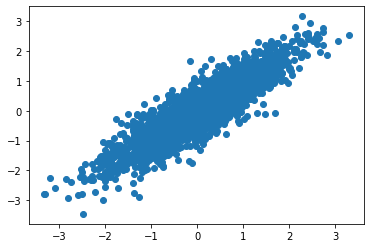

In [133]:
sampler = GaussianSampler(sample_dim).cuda()
#print("The corvariance of Gaussian is {}".format(sampler.get_covariance().cpu().detach().numpy()))
x_sample, y_sample = sampler.gen_samples(1000, cuda = False)
plt.scatter(x_sample, y_sample)
plt.show()

In [139]:
np.shape(y_sample)

(1000, 2)

Then we optimize parameter $\theta$ to minimize the mutual information with only samples from the Gaussian distribution.

In [130]:
mi_estimator = eval(estimator_name)(sample_dim, sample_dim, hidden_size).cuda()

sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = lr)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

mi_true_values = []
mi_est_values = []
min_mi = 100.

for i in range(num_iter):
    sampler.train()
    mi_estimator.eval()
    x_samples, y_samples = sampler.gen_samples(batch_size)
    sampler_loss = mi_estimator(x_samples, y_samples)
    sampler_optimizer.zero_grad()
    sampler_loss.backward() # retain_graph=True)
    sampler_optimizer.step()

    for j in range(5):
        mi_estimator.train()
        x_samples, y_samples = sampler.gen_samples(batch_size)
        
        print(x_samples.size())
        mi_loss = mi_estimator.learning_loss(x_samples, y_samples)
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()

    mi_true_values.append(sampler.get_MI())
    mi_est_values.append(mi_estimator(x_samples, y_samples))
    if i % 100 ==0:
        print("step {}, true MI value {}".format(i, sampler.get_MI()))

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
step 0, true MI value 1.5810962915420532
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([10

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
step 1100, true MI value 1.2382993

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
step 1600, true MI value 0.7949413061141968
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size(

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
step 2700, true MI value 0.2794065475463867
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size(

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
step 3200, true MI value 0.18401667475700378
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
step 4800, true MI value 0.0371571

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

We can plot the true MI values and the estimated MI values in each batch. The true MI value continuously decreases during the training. The estimated MI value first increases then decreases. The beginning increasing of estimated MI is because the estimator has not learned well from the samples. Then the decreasing process is the result of minimizing MI as learning loss.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

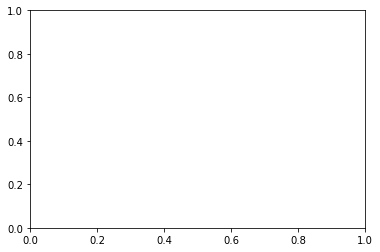

In [6]:
plt.plot(np.arange(len(mi_est_values)), mi_est_values, label=estimator_name + " est")
plt.plot(np.arange(len(mi_true_values)), mi_true_values, label="True MI value")
plt.legend()
plt.show()


We can plot samples of the optimized Gaussian sampler again, where the linear correlation between $x$ and $y$ has disappeared.

In [99]:
x_sample, y_sample = sampler.gen_samples(1000, cuda=False)
plt.scatter(x_sample, y_sample)
plt.show()

TypeError: gen_samples() got an unexpected keyword argument 'cuda'

## ICA/BSS problem

Introduce variables x ~ Gamma and y ~ Maxwell. Then mix them with a 2x2 mixing matrix W. We will then perform ICA to recover the components. 

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [28]:
from torch.distributions.gamma import Gamma
from torch.distributions.cauchy import Cauchy

In [274]:
class ICASampler(nn.Module):
    def __init__(self, W):
        super().__init__()
        self.W = torch.nn.Parameter(torch.tensor(W, requires_grad = True)) #Mixing matrix
        self.gamma = Gamma(torch.tensor([2.0]), torch.tensor([2.0]))
        self.cauchy = Cauchy(torch.tensor([0.0]), torch.tensor([1.0]))
        
    def get_W(self):
        return self.W

    def gen_samples(self, num_sample):
        
        gamma_samples = self.gamma.rsample(torch.tensor([num_sample]))
        cauchy_samples = self.cauchy.rsample(torch.tensor([num_sample]))
        
        inputs = torch.cat([gamma_samples, cauchy_samples], dim=1)
        
        samples = inputs @ self.W  
        #if not cuda:
            #samples = samples.cpu().detach().numpy()
            
        return samples


In [275]:
class ICADecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(2, 2)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        samples_out = self.lin(samples)
        return samples_out[:, 0], samples_out[:, 1]
    
    def get_W(self):
        return self.W
        

In [355]:
W =[[1.0, 2.0],[-5.0, 3.0]]
sampler = ICASampler(W)
data = sampler.gen_samples(1000)

decoder = ICADecoder()

In [285]:
from torch.utils.data import TensorDataset, DataLoader

In [453]:
W =[[1.0, 2.0],[-5.0, 3.0]]
sampler = ICASampler(W)
data = sampler.gen_samples(1000)

decoder = ICADecoder()


lr = 1e-4
batch_size = 100
num_epochs = 5000
sample_dim = 1
hidden_size = 15

decoder = ICADecoder()
mi_estimator = CLUBSample(1, 1, hidden_size)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

mi_est_values = []

# create datasets and dataloaders
data_set = TensorDataset(data[:, 0], data[:, 1])
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True) 

for epoch in range(1, num_epochs + 1):
    if epoch%1000==0: 
        print(epoch)
    
    for x_samples, y_samples in data_loader:

        if epoch%2==0:
            #decoder.train()
            #mi_estimator.eval()
            x_samples_out, y_samples_out = decoder(x_samples, y_samples)
            decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
                #print(decoder_loss)
            decoder_optimizer.zero_grad()
            decoder_loss.backward(retain_graph=True)
            decoder_optimizer.step()
            
            #x_samples_out, y_samples_out = decoder(x_samples, y_samples)
            #mi_est_values.append(mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).detach().numpy())
        
        #for j in range(5):
        
        #mi_estimator.train()
        x_samples_out, y_samples_out = decoder(x_samples, y_samples)
        mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()

    x_samples_out, y_samples_out = decoder(x_samples, y_samples)
    mi_est_values.append(mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).detach().numpy())
    

1000
2000
3000
4000
5000


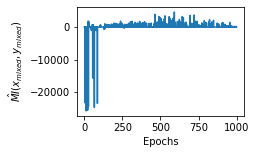

In [454]:
plt.figure(figsize=(3,2))
plt.plot(mi_est_values[:1000])
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')
plt.savefig('MI_versus_epochs.png')

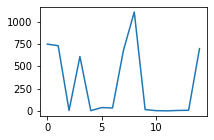

In [455]:
plt.figure(figsize=(3,2))
plt.plot(mi_est_values[1000:1015])

In [456]:
for param in decoder.parameters():
    print(param)

Parameter containing:
tensor([[-0.0900,  0.1454],
        [ 0.4162,  0.6945]], requires_grad=True)
Parameter containing:
tensor([-0.2426, -1.0449], requires_grad=True)


In [457]:
x_samples, y_samples = decoder(data[:, 0], data[:, 1])

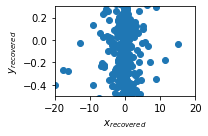

In [458]:
plt.figure(figsize=(3,2))
plt.scatter(x_samples.detach().numpy(), y_samples.detach().numpy())
plt.xlim([-20, 20])
plt.ylim([-0.5, 0.3])
plt.ylabel('$y_{recovered}$')
plt.xlabel('$x_{recovered}$')
plt.tight_layout()
plt.savefig('recovered_scatter.png')

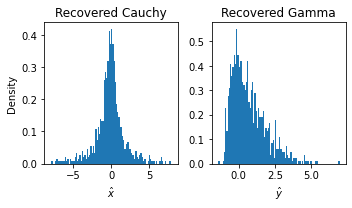

In [459]:
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.hist(x_samples.detach().numpy(), bins=100, density=True, range=[-8, 8])
plt.ylabel('Density')
plt.xlabel('$\hat{x}$')
plt.title('Recovered Cauchy')
plt.subplot(1, 2, 2)
plt.hist(y_samples.detach().numpy(), bins=100, density=True)
plt.xlabel('$\hat{y}$')
plt.title('Recovered Gamma')
plt.tight_layout()
plt.savefig('recovered_distributions.png')

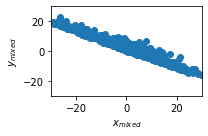

In [460]:
plt.figure(figsize=(3,2))
plt.scatter(data.detach().numpy()[:, 0], data.detach().numpy()[:, 1])
plt.xlim([-30, 30])
plt.ylim([-30, 30])
plt.ylabel('$y_{mixed}$')
plt.xlabel('$x_{mixed}$')
plt.tight_layout()
plt.savefig('mixed_components.png')

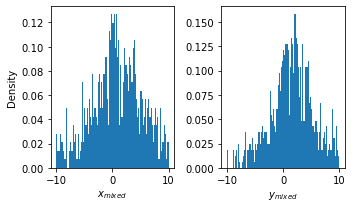

In [461]:
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.hist(data.detach().numpy()[:,0], bins=100, density=True, range=[-10, 10])
plt.ylabel('Density')
plt.xlabel('$x_{mixed}$')

plt.subplot(1, 2, 2)
plt.hist(data.detach().numpy()[:,1], bins=100, density=True, range=[-10, 10])
plt.xlabel('$y_{mixed}$')

plt.tight_layout()
plt.savefig('mixed_distributions.png')

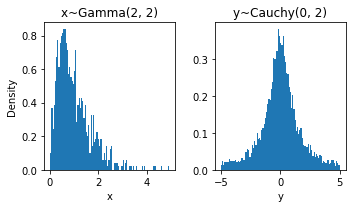

In [263]:
g = Gamma(torch.tensor([2.0]), torch.tensor([2.0])).rsample(torch.tensor([1000]))
c = Cauchy(torch.tensor([0.0]), torch.tensor([2])).rsample(torch.tensor([1000]))

plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.hist(g.numpy(), bins=100, density=True)
plt.ylabel('Density')
plt.xlabel('x')
plt.title('x~Gamma(2, 2)')
plt.subplot(1, 2, 2)
plt.hist(c.numpy(), bins=100, range=[-5, 5], density=True)
plt.xlabel('y')
plt.title('y~Cauchy(0, 2)')
plt.tight_layout()
plt.savefig('original_distributions.png')

In [ ]:
plt.scatter(g.umpy(), c.numpy())
plt.xlim([-25, 25])
plt.ylim([-25, 25])

(-25.0, 25.0)

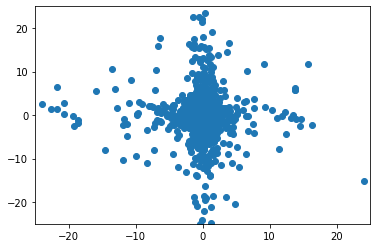

In [74]:
plt.scatter(c1.numpy(), c2.numpy())
plt.xlim([-25, 25])
plt.ylim([-25, 25])

(0.0, 10.0)

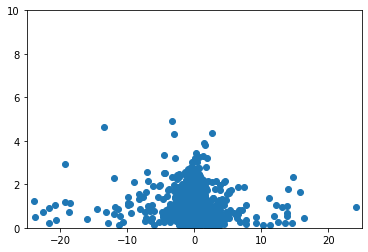

In [77]:
plt.scatter(c1.numpy(), g.numpy())
plt.xlim([-25, 25])
plt.ylim([0, 10])

# BSS with time-dependent signals

In [8]:
def gen_sine_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, len(t))
    y = A*np.sin(w*t + phase) + noise + baseline
    return y

In [9]:
t = np.linspace(0, 20, 1000)
sine = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0.5)

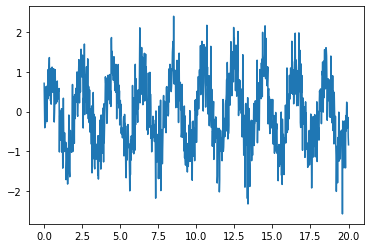

In [10]:
plt.plot(t, sine)

In [11]:
from scipy import signal

def gen_square_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, len(t))
    y = A*signal.square(w*t + phase) + baseline + noise
    return y
    

In [12]:
square = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0.5)

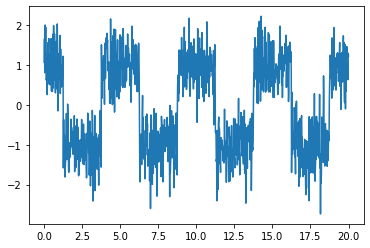

In [13]:
plt.plot(t, square)

### Now mix the two signals together with a mixing matrix

In [680]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [681]:
square = torch.tensor(square)
sine = torch.tensor(sine)
inputs = torch.stack((square, sine))

In [682]:
W = torch.tensor([[1, 1.5], [-1, 0.75]])
data = W @ inputs.float()

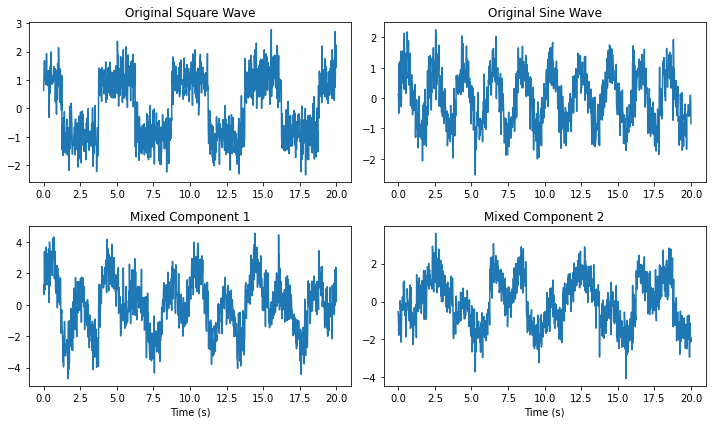

In [692]:
plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.title('Original Square Wave')
plt.plot(t, square.numpy())

plt.subplot(2, 2, 2)
plt.title('Original Sine Wave')
plt.plot(t, sine.numpy())

plt.subplot(2,2,3)
plt.title('Mixed Component 1')
plt.plot(t, data[0,:].numpy())
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.title('Mixed Component 2')
plt.plot(t, data[1,:].numpy())
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('time_dept_signal_mixing.jpeg')

### Now optimize the decoder to recover the two signals

In [684]:
data = data.T

In [685]:
data

tensor([[ 0.8255, -0.5436],
        [ 1.2713, -1.0079],
        [ 0.6605, -1.7817],
        ...,
        [ 2.3878, -2.1664],
        [ 1.6765, -1.8816],
        [ 0.1982, -2.1020]])

In [686]:
decoder = ICADecoder()
lr = 1e-4
batch_size = 100
num_epochs = 5000
sample_dim = 1
hidden_size = 15

decoder = ICADecoder()
mi_estimator = CLUBSample(1, 1, hidden_size)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

mi_est_values = []

# create datasets and dataloaders
print(np.shape(data))
data_set = TensorDataset(data[:, 0], data[:, 1])
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False) 

for epoch in range(1, num_epochs + 1):
    if epoch%1000==0: 
        print(epoch)
    
    for x_samples, y_samples in data_loader:

        #print(x_samples.size())
        if epoch%5==0:
            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
            decoder_optimizer.zero_grad()
            decoder_loss.backward(retain_graph=True)
            decoder_optimizer.step()
            
            #x_samples_out, y_samples_out = decoder(data[:, 0].float(), data[:, 1].float())
            #mi_est_values.append(mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).detach().numpy())

        #print(x_samples)
        #print(y_samples)
        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
        mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()
        
    if epoch%5==0:
        x_samples_out, y_samples_out = decoder(data[:, 0].float(), data[:, 1].float())
        mi_est_values.append(mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).detach().numpy())
        
        #if mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).detach().numpy() < 10**-6:
            #break
    

torch.Size([1000, 2])
1000
2000
3000
4000
5000


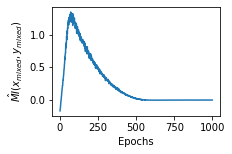

In [693]:
plt.figure(figsize=(3,2))
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')
plt.savefig('MI_versus_epochs_timedept.jpeg')

torch.Size([1000, 2])
torch.Size([1000])


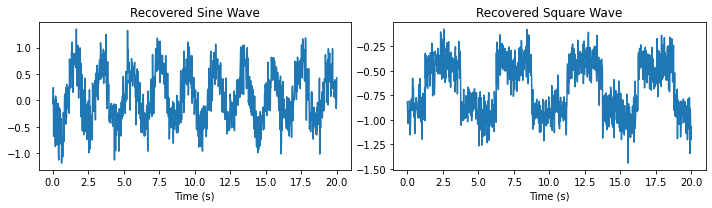

In [697]:
print(np.shape(data))
x_samples, y_samples = decoder(data[:, 0].float(), data[:, 1].float())
print(x_samples.size())

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples.detach().numpy())
#plt.ylabel('Density')
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(t, y_samples.detach().numpy())
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('recovered_components.jpeg')

# BSS on convolutive mixtures

In [199]:
class ConvolutionSampler(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        
        t = torch.arange(0, 200)
        tau1 = 5
        tau2 = 15
        k1 = torch.flip(torch.exp(-t/tau1), dims=[-1])
        k2 = torch.flip(torch.exp(-t/tau2), dims=[-1])
        
        
        for param in self.conv.parameters():
            param.data = torch.stack((k1, k2)).unsqueeze(1)
            
        #self.linear = nn.Linear(2, 2)
        self.W = torch.nn.Parameter(torch.tensor([[1.0, 1.5], [-1.0, 0.75]], requires_grad = True))
        #for param in self.linear.parameters():
            #param.data = W

    def forward(self, x):
        y = self.conv(x).double()
        return y.squeeze(0).T.double() @ self.W.double()
        

In [200]:
sampler2 = ConvolutionSampler()

In [201]:
x = torch.zeros((1, 2, 10000))
x[0, 0, 500] = 1
x[0, 1, 1000] = 1
y = sampler2(x)

x.type()

'torch.FloatTensor'

In [202]:
y.size()

torch.Size([10000, 2])

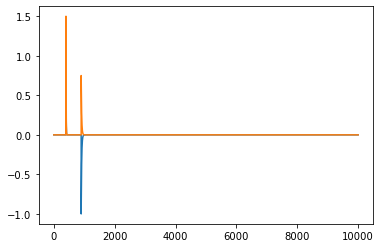

In [203]:
plt.plot(y[:, 0].detach().numpy())
plt.plot(y[:, 1].detach().numpy())

### Convolutive mixture of origianl inputs

In [231]:
t = np.linspace(0, 20, 10000)
sine = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0.25)
square = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0.25)

square = torch.tensor(square)
sine = torch.tensor(sine)
inputs = torch.stack((square, sine))
inputs.unsqueeze(0).size()
print(inputs.type())

torch.DoubleTensor


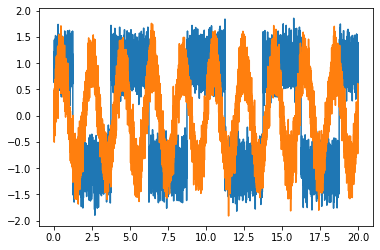

In [232]:
plt.plot(t, square)
plt.plot(t, sine)

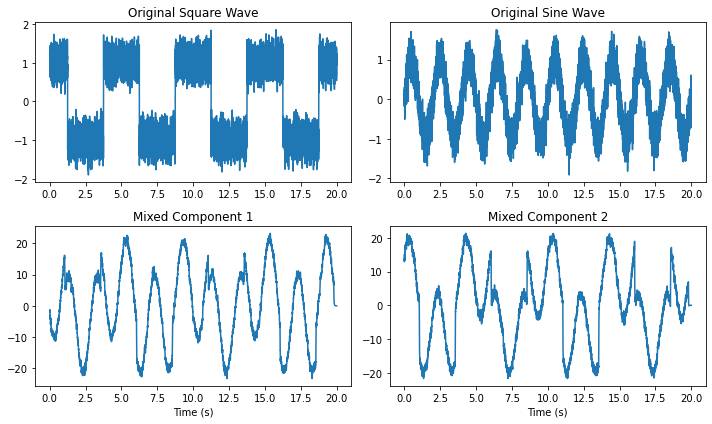

In [233]:
y = sampler2(inputs.unsqueeze(0).float())
#print(y.size())

plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.title('Original Square Wave')
plt.plot(t, inputs[0,:])

plt.subplot(2, 2, 2)
plt.title('Original Sine Wave')
plt.plot(t, inputs[1, :])

plt.subplot(2,2,3)
plt.title('Mixed Component 1')
plt.plot(t, y[:, 0].detach().numpy())
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.title('Mixed Component 2')
plt.plot(t, y[:, 1].detach().numpy())
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('time_dept_signal_convolutive_mixing.jpeg')

#y = sampler2(data.T.unsqueeze(0))
#plt.plot(y[:, 0].detach().numpy())
#plt.plot(y[:, 1].detach().numpy())

In [207]:
class ConvolutiveDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        
        t = torch.arange(0, 200)
        tau1 = 5
        tau2 = 15
        k1 = torch.flip(torch.exp(-t/tau1), dims=[-1])
        k2 = torch.flip(torch.exp(-t/tau2), dims=[-1])
        
        
        for param in self.conv.parameters():
            param.data = torch.stack((k1, k2)).unsqueeze(1)
        
        
        
        self.lin = nn.Linear(2, 2)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        samples = samples.T.unsqueeze(0)
        samples_out = self.conv(samples)
        samples_out = samples_out.squeeze(0).T
        samples_out = self.lin(samples_out)
        return samples_out[:, 0], samples_out[:, 1]
    
    #def forward(self, x_samples, y_samples):
        #samples = torch.stack((x_samples, y_samples), dim=1)
        #lin_out = self.lin(samples)
        #lin_out = lin_out.T.unsqueeze(0)
        #samples_out = self.conv(lin_out)
        #samples_out = samples_out.squeeze(0).T
        #return samples_out[:, 0], samples_out[:, 1]

In [208]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [234]:
y = y.to(dev)
#lr = 1e-4
lr=1e-4
batch_size = 1000 # equal to the length of the input
num_epochs = 1000
sample_dim = 1
hidden_size = 25

decoder = ConvolutiveDecoder().to(dev)
mi_estimator = CLUBSample(1, 1, hidden_size).to(dev)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
#decoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'min')
decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.999)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)
#mi_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mi_optimizer, 'min')
mi_scheduler = torch.optim.lr_scheduler.ExponentialLR(mi_optimizer, gamma=0.999)

mi_est_values = []

num_batches = len(y[:,0]) // batch_size
print('num:', num_batches)
num_mini_batches = 500


#num_warm_up = 50
#for k in range(num_warm_up):
        #for i in range(num_mini_batches):
            #random_indx = np.random.randint(num_batches, size=2)
            #n = random_indx[0]
            #m = random_indx[1]

            #x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())

            #x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
            #y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]

            #mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
            #mi_optimizer.zero_grad()
            #mi_loss.backward()
            #mi_optimizer.step()



for epoch in range(1, num_epochs + 1):
    if epoch%100==0: 
        print(epoch)
    
    for i in range(num_mini_batches):
        # randomly draw minibatch for x_samples and y_samples
        random_indx = np.random.randint(num_batches, size=2)
        n = random_indx[0]
        m = random_indx[1]

        x_samples = y[:, 0]
        y_samples = y[:, 1]

        if epoch%20==0:
            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            
            x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
            y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
            
            decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
            decoder_optimizer.zero_grad()
            decoder_loss.backward(retain_graph=True)
            decoder_optimizer.step()
            #decoder_scheduler.step(decoder_loss)
            #mi_est_values.append(decoder_loss.cpu().detach().numpy())
            

        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
        
        x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
        y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
        
        mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()
        #mi_scheduler.step(mi_loss)
        #decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
        #mi_est_values.append(decoder_loss.cpu().detach().numpy())
        
        
    if epoch%20==0:
        decoder_scheduler.step()
    #mi_scheduler.step()
    
    if epoch%20==0:
        x_samples_out, y_samples_out = decoder(y[:, 0].float(), y[:, 1].float())
        x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
        y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
        mi = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).cpu().detach().numpy()
        mi_est_values.append(mi)
        
        if np.absolute(mi)<1e-8:
            break
        

num: 10
100
200
300
400
500
600
700
800
900
1000


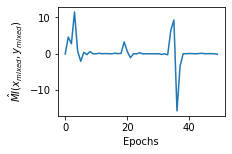

In [235]:
plt.figure(figsize=(3,2))
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')
plt.savefig('MI_versus_epochs_timedept_convolution.jpeg')

torch.Size([10000])


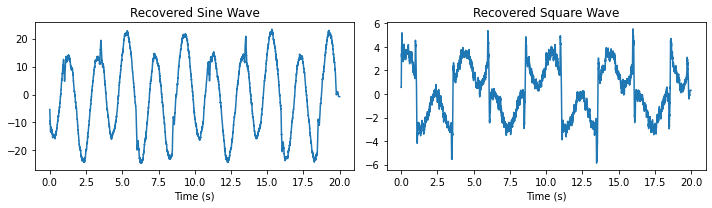

In [236]:
#print(np.shape(data))
x_samples, y_samples = decoder(y[:, 0].float(), y[:, 1].float())
print(x_samples.size())

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples.cpu().detach().numpy())
#plt.plot(t, sine.numpy())
#plt.ylabel('Density')
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(t, y_samples.cpu().detach().numpy())
#plt.plot(t, square.numpy())
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('recovered_components_convolution4.jpeg')

In [237]:
import scipy.stats as ss

def signal_clarity(sources, inputs):
    #r = ss.pearsonr(sources, inputs)
    r = np.corrcoef(sources, inputs)
    c = np.absolute(np.diff(np.absolute(r), axis=0))
    return np.mean(c)

In [238]:
import sklearn.preprocessing as sklp

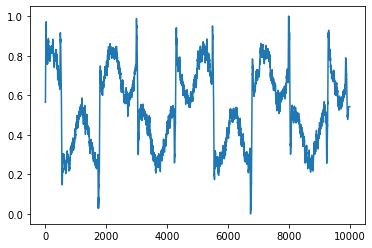

In [239]:
sources = sklp.minmax_scale(y_samples.cpu().detach().numpy())
#plt.plot(sources[:, 0])
plt.plot(sources)

(2, 10000)
(2, 10000)


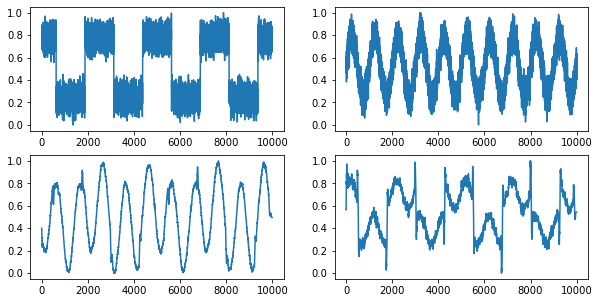

In [240]:
recovered = np.vstack((sklp.minmax_scale(x_samples.cpu().detach().numpy()), sklp.minmax_scale(y_samples.cpu().detach().numpy())))
original = sklp.minmax_scale(inputs.T).T
print(np.shape(original))
print(np.shape(recovered))

plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
plt.plot(original[0, :])
plt.subplot(2, 2, 2)
plt.plot(original[1, :])
plt.subplot(2,2,3)
plt.plot(recovered[0, :])
plt.subplot(2,2,4)
plt.plot(recovered[1, :])

In [241]:
clarity = signal_clarity(original, recovered)
clarity

0.5037042274580935

In [242]:
np.corrcoef(original[0, :], original[1, :]) # baseline correlation. what is the best?

array([[ 1.        , -0.00185292],
       [-0.00185292,  1.        ]])

### Try changing trianing to sum of mutual information over multiple samples

In [16]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [31]:
class ConvolutiveDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        self.lin = nn.Linear(2, 2)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        samples = samples.T.unsqueeze(0)
        samples_out = self.conv(samples)
        samples_out = samples_out.squeeze(0).T
        samples_out = self.lin(samples_out)
        return samples_out[:, 0], samples_out[:, 1]
    
    #def forward(self, x_samples, y_samples):
        #samples = torch.stack((x_samples, y_samples), dim=1)
        #lin_out = self.lin(sample)
        #lin_out = lin_out.T.unsqueeze(0)
        #samples_out = self.conv(lin_out)
        #samples_out = samples_out.squeeze(0).T
        
        
        #return samples_out[:, 0], samples_out[:, 1]

In [33]:
y = y.to(dev)
print(y.device)
print(y.size())

lr = 1e-4
batch_size = 200 # equal to the length of the input
num_epochs = 1000
sample_dim = 1
hidden_size = 20

decoder = ConvolutiveDecoder().to(dev)
mi_estimator = CLUBSample(1, 1, hidden_size).to(dev)


decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

mi_est_values = []

M=5 # number of terms to sum over for MI cost function


num_batches = len(y[:,0]) // batch_size
print('num:', num_batches)
num_mini_batches = 100

for epoch in range(1, num_epochs + 1):
    if epoch%200==0: 
        print(epoch)
    
    for i in range(num_mini_batches):
        # randomly draw minibatch for x_samples and y_samples
        random_indx = np.random.randint(num_batches, size=(2, M))
        
        n = random_indx[0, 0]
        m = random_indx[1, 0]
            
        x_samples = y[n*batch_size : n*batch_size+batch_size, 0]
        y_samples = y[m*batch_size : m*batch_size+batch_size, 1]
        
        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
        mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
        

        for j in range(1, M):
            
            n = random_indx[0, j]
            m = random_indx[1, j]
            
            x_samples = y[n*batch_size : n*batch_size+batch_size, 0]
            y_samples = y[m*batch_size : m*batch_size+batch_size, 1]
            
            
            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            mi_loss += mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
        
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()
            

        if epoch%10==0:
            
            n = random_indx[0, 0]
            m = random_indx[1, 0]
            
            x_samples = y[n*batch_size : n*batch_size+batch_size, 0]
            y_samples = y[m*batch_size : m*batch_size+batch_size, 1]
            
            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
            
            for j in range(1, M):
                
                n = random_indx[0, j]
                m = random_indx[1, j]
            
                x_samples = y[n*batch_size : n*batch_size+batch_size, 0]
                y_samples = y[m*batch_size : m*batch_size+batch_size, 1]
            
                x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
                decoder_loss += mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
            
            decoder_optimizer.zero_grad()
            decoder_loss.backward(retain_graph=True)
            decoder_optimizer.step()
            
            mi_est_values.append(decoder_loss.cpu().detach().numpy())

            #x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            #mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
            #mi_optimizer.zero_grad()
            #mi_loss.backward()
            #mi_optimizer.step()
        
    #if epoch%10==0:
        #x_samples_out, y_samples_out = decoder(y[:, 0].float(), y[:, 1].float())
        #mi_est_values.append(mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T).cpu().detach().numpy())

cuda:0
torch.Size([10000, 2])
num: 50
200
400
600
800
1000


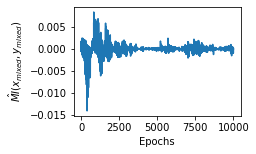

In [34]:
plt.figure(figsize=(3,2))
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')
plt.savefig('MI_versus_epochs_timedept_convolution2.jpeg')

torch.Size([10000])


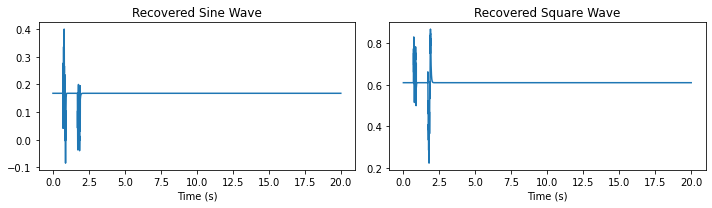

In [35]:
x_samples, y_samples = decoder(y[:, 0].float(), y[:, 1].float())
print(x_samples.size())

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples.cpu().detach().numpy())
#plt.plot(t, sine.numpy())
#plt.ylabel('Density')
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(t, y_samples.cpu().detach().numpy())
#plt.plot(t, square.numpy())
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('recovered_components_convolution2.jpeg')